# Investigating EHR data from PIC-SURE

The purpose of this notebook is to help researchers get started with EHR analysis in python using clinical data exported from PIC-SURE. 

### About the data
This example code uses a synthetically generated dataset from Synthea, an open-source patient population simulation. 
The dataset has been formatted to mirror what a data export from PIC-SURE may look like.  
It includes all age groups and is not limited to pediatric patients. 



Jason Walonoski, Mark Kramer, Joseph Nichols, Andre Quina, Chris Moesel, Dylan Hall, Carlton Duffett, Kudakwashe Dube, Thomas Gallagher, Scott McLachlan, Synthea: An approach, method, and software mechanism for generating synthetic patients and the synthetic electronic health care record, Journal of the American Medical Informatics Association, Volume 25, Issue 3, March 2018, Pages 230–238, https://doi.org/10.1093/jamia/ocx079

###  Installing packages
The following code installs and loads packages needed for basic data management and manipulation.


In [3]:
options(repos = c(CRAN = "https://cloud.r-project.org/"))

install.packages('tidyverse')
install.packages('lubridate')

library(tidyverse)
library(lubridate)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Loading the data
The following code downloads the dataset.

In [6]:
# The data is stored on github:
url <- "https://github.com/hms-dbmi/pic-sure-public-datasets/raw/main/synthea_10k_picsure_format.csv.zip"

# Temporary file to store the ZIP
temp_zip <- tempfile(fileext = ".zip")
GET(url, write_disk(temp_zip, overwrite = TRUE))
files <- unzip(temp_zip, list = TRUE)

# Extract and read the CSV file
csv_file <- files$Name[1]
data <- read_csv(unz(temp_zip, csv_file))

# Clean up temporary files
unlink(temp_zip)

Response [https://raw.githubusercontent.com/hms-dbmi/pic-sure-public-datasets/main/synthea_10k_picsure_format.csv.zip]
  Date: 2025-02-04 23:15
  Status: 200
  Content-Type: application/zip
  Size: 23.6 MB
<ON DISK>  /tmp/RtmpopjT30/file3e3c674ac25a.zipNULL

Rows: 3737903 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): CONCEPT_PATH, TVAL_CHAR
dbl (3): PATIENT_NUM, NVAL_NUM, TIMESTAMP

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Taking a first look at the dataset
Let's use the `head()` function to take a first look at the dataset. 
You'll see 5 columns:
* PATIENT_NUM: Represents a unique patient identifier
* CONCEPT_PATH: Represents the clinical variable for a given observation (row)
* TVAL_CHAR: The text / character value of the clinical variable, if applicable
* NVAL_NUM: The numerical value of the clinical variable, if applicable
* TIMESTAMP: The date and time associated to a given observation (row)

In [7]:
# The timestamp is in unix format. Convert to datetime
data$TIMESTAMP <- as.POSIXct(data$TIMESTAMP, origin = "1970-01-01", tz = "UTC")

head(data)

PATIENT_NUM,CONCEPT_PATH,NVAL_NUM,TVAL_CHAR,TIMESTAMP
<dbl>,<chr>,<dbl>,<chr>,<dttm>
1,\ACT Demographics\Sex\,NA,Female,2024-12-10 05:00:00
1,\ACT Demographics\Race\,NA,White,2024-12-10 05:00:00
1,\ACT Demographics\Hispanic\,NA,No,2024-12-10 05:00:00
2,\ACT Demographics\Sex\,NA,Male,2024-12-10 05:00:00
2,\ACT Demographics\Race\,NA,White,2024-12-10 05:00:00
2,\ACT Demographics\Hispanic\,NA,No,2024-12-10 05:00:00


The EHR data represented in this dataset may be very large, making it difficult to explore manually. 

You'll notice that the `CONCEPT_PATH` column consists of a hierarchy that narrows down to a certain clinical variable. 

Let's take a look at the highest level of the `CONCEPT_PATH` to see what kind of data we have. We can consider this to be the `VARIABLE_TYPE`.

In [8]:
# Isolate the variable type using regular expressions, and create a new column for variable type
data$VARIABLE_TYPE = str_extract(data$CONCEPT_PATH, "(?<=\\\\)[^\\\\]+(?=\\\\)")
# Count how many observations are associated with each variable type
table(data$VARIABLE_TYPE)


    ACT Demographics ACT Diagnosis ICD-10 ACT Lab Test Results 
               48222                96705              2788447 
     ACT Medications   ACT Procedures CPT 
              748721                55808 

As seen above, this dataset contains the following data types: 
- ACT Lab Test Results (Labs)
- ACT Medications
- ACT Diagnosis ICD-10 (Diagnoses)
- ACT Procedures CPT (Procedures)
- ACT Demographics


#### Working with patient demographics from the dataset
Here we will explore, organize and visualize the demographic data available in our dataset. This includes age, sex and race.

This dataset should contain about 10,000 synthetic patient records. Let's verify this by checking the count of unique patient IDs present in the dataset. 

In [9]:
n_distinct(data$PATIENT_NUM)


[1] 11644

Let's also check what date ranges are represented in our dataset. 


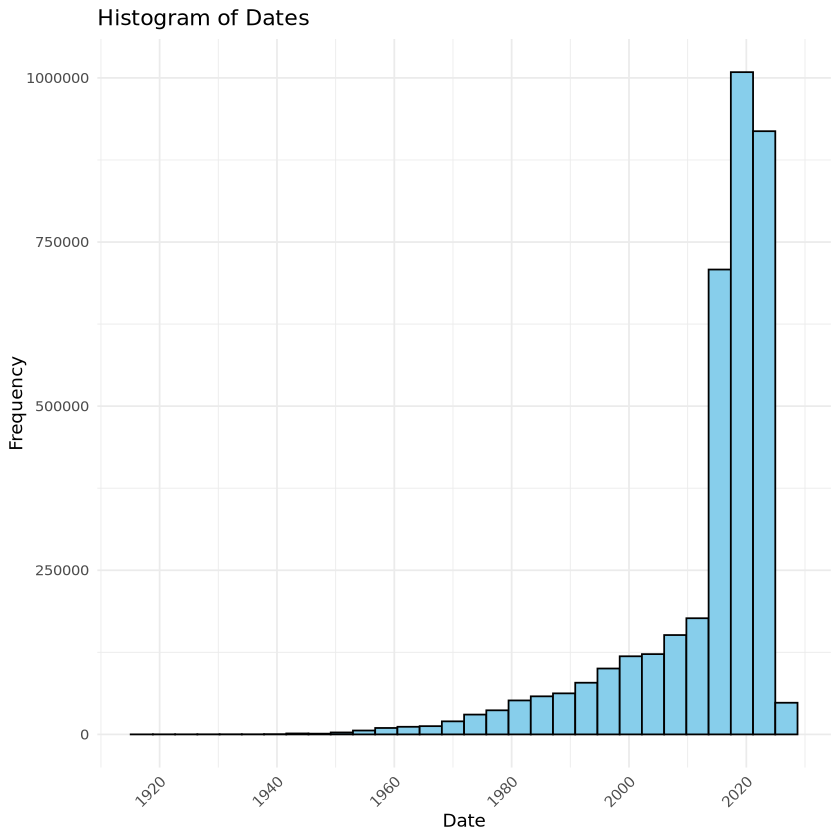

In [10]:
# Extracting date from timestamp column
data <- data %>%
  mutate(TIMESTAMP = ymd_hms(TIMESTAMP, quiet = TRUE), # Convert to datetime
         DATE = as.Date(TIMESTAMP)) # Extract date

# Create a histogram of dates
ggplot(data, aes(x = DATE)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black") +
  labs(x = "Date", y = "Frequency", title = "Histogram of Dates") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

The majority of our dataset is from the last 15 years, as expected. 

We also see data stretching far back to 1920; perhaps this is associated with a patient's age. Depending on your research question, you may want to investigate those outliers. 

## Exploring Demographic Data
Here we will explore, organize and visualize the demographic data available in our dataset. This includes age, sex and race.

Let's create a new dataframe called `demo_df` that will only include the demographics information.

In [11]:
# Create a new dataframe including only the demographics data:

demo_df <- data %>%
  filter(VARIABLE_TYPE == 'ACT Demographics')


Let's first take a look at the **sex** breakdown. 

We can find the Sex related observations by searching for this value in the CONCEPT_PATH column. Then, we take the sex related values (found in the TVAL_CHAR column) and transform them into a new column, "sex". 

In [12]:
# isolating and showing sex data:

sex_df <- demo_df %>%
  filter(grepl("Sex", CONCEPT_PATH)) %>%
  select(PATIENT_NUM, TVAL_CHAR)

# renaming the column title to "sex":
sex_df<- sex_df %>%
  rename(sex=TVAL_CHAR)

head(sex_df)

PATIENT_NUM,sex
<dbl>,<chr>
1,Female
2,Male
3,Male
4,Female
5,Female
6,Male


Creating a table to show the sex distribution of the dataset:


In [13]:
# grouping by sex and calculating the percentage of each:
sex_count<- sex_df %>%
  group_by(sex) %>%
  summarise(count=n()) %>%
  mutate(percentage = (count / sum(count)) * 100)

sex_count

sex,count,percentage
<chr>,<int>,<dbl>
Female,5747,49.35589
Male,5897,50.64411


Now let's look at the **age** distribution of our patients. 

Below, we isolate the age data by searching the CONCEPT_PATH for Age. Then, we take the age related values (found in the NVAL_NUM column) and transform them into a new column, "age". 


In [14]:
# isolating and showing age data + renaming column title to "age":
age_df<- demo_df %>%
   filter(grepl("Age", CONCEPT_PATH)) %>%
  select(PATIENT_NUM, NVAL_NUM) %>%
  rename(age=NVAL_NUM) %>%
  arrange(PATIENT_NUM)

We can now use this age dataframe to plot the age distribution in our data. 


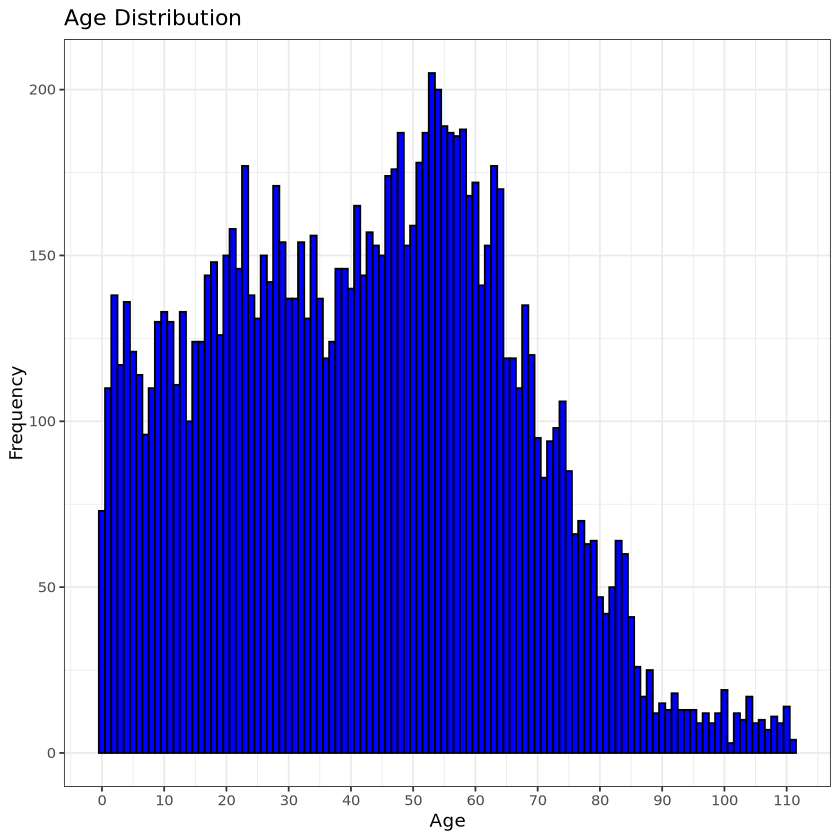

In [15]:
#Creating a histogram, demonstrating the age distribution:

ggplot(data = age_df) +
  geom_histogram(aes(x=age), binwidth = 1, fill = "blue", color = "black") +
  theme_bw() +
  scale_x_continuous(n.breaks=18)+
  labs(x = "Age", y = "Frequency", title = "Age Distribution")


We can also group our patients into age groups and create a table detailing how many patients are in each age group. 

We will group our patients into the following groups: 
* under 18
* 18-65
* 65+


In [16]:
# grouping by age (<18 , 18-65, 65+)

age_groups<- age_df %>%
  mutate(age_group= case_when(age < 18 ~ "<18",
                    age >= 18 & age <65 ~ "18-65",
                   age >=65 ~ "65+"))

# calculating number of patients in each group

age_group_sum<- age_groups %>%
  group_by(age_group)%>%
  summarize(count=n()) %>%
  arrange(factor(age_group, levels = c("<18", "18-65", "65+")))

age_group_sum

age_group,count
<chr>,<int>
<18,2144
18-65,7437
65+,2063


Finally, let's investigate the **race** distribution. 

Similarly to above, we isolate the race data by searching the CONCEPT_PATH for Race. Then, we take the race related values (found in the TVAL_CHAR column) and transform them into a new column, "race". 

In [17]:
# isolating race data + renaming column title to "race":
race_df<- demo_df %>%
  filter(grepl("Race", CONCEPT_PATH)) %>%
   select(PATIENT_NUM, TVAL_CHAR)%>%
  rename(race=TVAL_CHAR)


creating a table of the race distribution


In [18]:
# grouping by race and calculating the percentage of each:

race_count <- race_df %>%
  group_by(race) %>%
  summarise(count = n()) %>%
  mutate(percentage = round((count / sum(count)) * 100,2)) %>%
  mutate(race = fct_reorder(race, -percentage)) %>%
  arrange(-percentage)

race_count

race,count,percentage
<fct>,<int>,<dbl>
White,9648,82.86
Black or African American,918,7.88
Asian,786,6.75
Native Hawaiian or Other Pacific Islander,118,1.01
No Information,113,0.97
American Indian or Alaska Native,61,0.52


We will plot these results in a bar plot. 


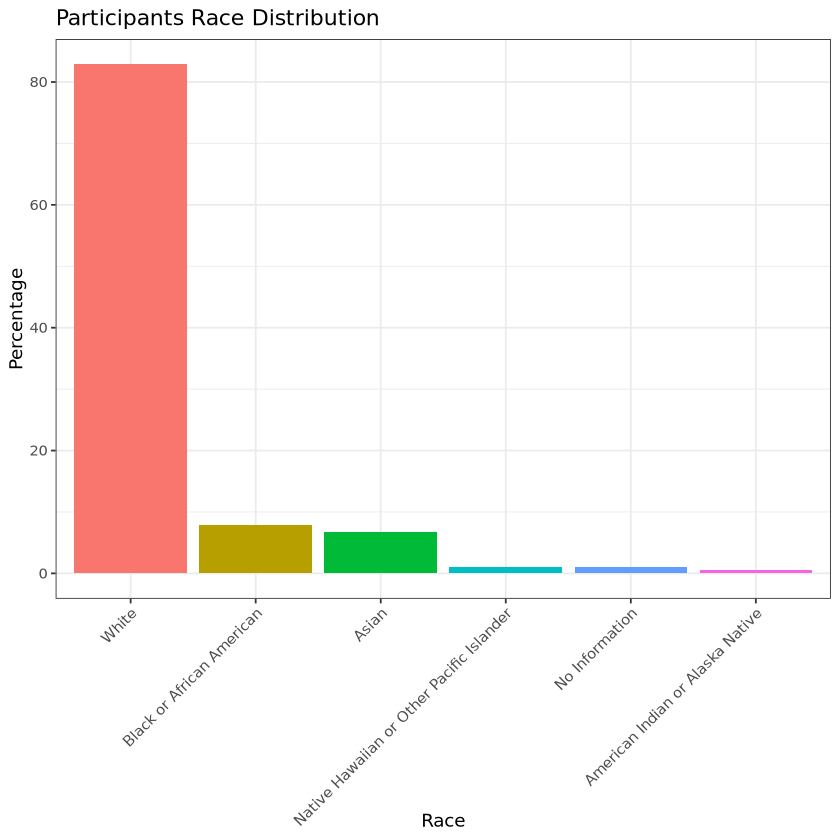

In [19]:
# create a bar plot representing race distribution:

ggplot(data= race_count) +
  geom_bar(aes(x=race, y=percentage, fill= race ), stat = "identity")+
  theme_bw()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  theme(legend.position = "none")+
  labs(x="Race",y="Percentage", title="Participants Race Distribution") 

The way our initial dataset is formatted can be difficult to view multiple variables about a given patient at the same time. 

Below, we create one table presenting all demographic data (age, sex, race) by patient ID. 

In [20]:
#merging all columns to show age, sex, race in one table:

demographics_joined<- age_df %>%
  left_join(sex_df, by="PATIENT_NUM") %>%
  left_join(race_df, by= "PATIENT_NUM")

head(demographics_joined)

PATIENT_NUM,age,sex,race
<dbl>,<dbl>,<chr>,<chr>
1,5,Female,White
2,15,Male,White
3,8,Male,White
4,60,Female,White
5,9,Female,White
6,56,Male,White


## Investigating ICD codes: Epilepsy case study
We can isolate the diagnosis related information by searching for 'ACT Diagnosis' in the CONCEPT_PATH column.

In [21]:
#create a new data frame including only diagnosis data:

diagnosis_icd10 <- data %>%
  filter(grepl("\\ACT Diagnosis ICD-10", CONCEPT_PATH))

### In this case study, we will investigate epilepsy as the disease of interest. 

Epilapsy is represented by  ICD group code "G40", which includes the following and their sub-groups:
* G40.0: Localization-related (focal) (partial) idiopathic epilepsy and epileptic syndromes with seizures of localized onset.
* G40.1: Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with simple partial seizures.
* G40.2: Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures.
* G40.3: Generalized idiopathic epilepsy and epileptic syndromes
* G40.A: Absence epileptic syndrome.
* G40.B: Juvenile myoclonic epilepsy [impulsive petit mal].
* G40.C: Lafora progressive myoclonus epilepsy, intractable.
* G40.4: Other generalized epilepsy and epileptic syndromes.
* G40.5: Epileptic seizures related to external causes.
* G40.8: Other epilepsy and recurrent seizures.
* G40.9: Epilepsy, unspecified.

*A full list of ICD-10 codes can be found at https://www.icd10data.com/ICD10CM/Codes*

### Isolating the patient cohort

First, we create a new data-frame that only includes patients with epilepsy.

We create a variable called `icd_code_of_interest` and set it to `G40`.

(you can replace the ICD code "G40" with the ICD code of your choice if you are interested in investigating a different disease group!):

You can see a preview of this epilepsy focused dataset below.

In [22]:
#filtering to include only patients diagnosed with epilepsy and recurrent seizures (ICD GROUP CODE G40):
icd_code_of_interest = 'G40'

epilepsy_icd10<- diagnosis_icd10 %>%
  filter(grepl(icd_code_of_interest, TVAL_CHAR)) %>%
  select(PATIENT_NUM, CONCEPT_PATH,TVAL_CHAR) %>%
  rename(icd_10_code= TVAL_CHAR) %>%
  group_by(PATIENT_NUM)

# creating a final list of patient_ids with epilepsy (G40 group code), removing any duplicate entries for same patient id :

epilepsy_icd10_patient_ids<- epilepsy_icd10 %>%
  select(PATIENT_NUM) %>%
  distinct() 

head(epilepsy_icd10)

PATIENT_NUM,CONCEPT_PATH,icd_10_code
<dbl>,<chr>,<chr>
9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
9,\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures,"G40.9 Epilepsy, unspecified"


Let's also isolate the demographic data for patients who have been diagnosed with epilepsy, and see how much of our dataset they represent.

In [23]:
# merging the patient id list with the demographic data
epi_demo<- epilepsy_icd10_patient_ids %>%
  left_join(demographics_joined, by= "PATIENT_NUM") %>%
  arrange(PATIENT_NUM)

head(epi_demo)

# calculating percentage of patients with epilepsy from original cohort:
percentage_epilepsy <-  (nrow(epilepsy_icd10_patient_ids) / n_distinct(data$PATIENT_NUM)) * 100

print(paste(round(percentage_epilepsy,2), '% of patients in our dataset have been diagnosed with an epilepsy ICD10 code.'))

PATIENT_NUM,age,sex,race
<dbl>,<dbl>,<chr>,<chr>
9,41,Male,Black or African American
87,62,Male,White
122,1,Female,Asian
149,15,Male,White
175,4,Male,White
206,66,Female,White


[1] "3.59 % of patients in our dataset have been diagnosed with an epilepsy ICD10 code."


### Investigating the presence of other diagnostic codes in our defined patient cohort
Our cohort consists of patients with epilepsy. 
Let's say we are interested in comparing which patients with epilepsy also have been diagnosed with migranes (ICD GROUP CODE G43).

We create a variable called `icd` and set it to `G43`. (you can replace the ICD code "G43" with the ICD code of your choice in the next chunk of code)

We then search for this ICD code of interest within our cohort. 

This will be done in a few steps.
(you can replace the ICD code "G43" with the ICD code of your choice in the next chunk of code):

In [24]:
# (ICD GROUP CODE G43)
icd <- 'G43'

##first, creating a data-frame including only patients diagnosed with migraines 

migraine_icd10<- diagnosis_icd10 %>%
  filter(grepl(icd,TVAL_CHAR)) %>% 
  select(PATIENT_NUM, CONCEPT_PATH,TVAL_CHAR) %>%
  rename(icd_10_code= TVAL_CHAR)%>%
  group_by(PATIENT_NUM)

#next, extracting only the patient id's and removing any duplicates.
migraine_icd10_patient_ids<- migraine_icd10 %>%
  select(PATIENT_NUM) %>%
  distinct()


#finally, merging the epilepsy patient id list with the migraine patient id list to create a list including only patients that have both epilepsy and migraine ICD10 codes 
epilepsy_migraine <- epilepsy_icd10_patient_ids %>%
  inner_join(migraine_icd10_patient_ids, by = "PATIENT_NUM")
  

Now, let's examine the original epilepsy dataframe and add a column indicating which patients also have migraines:

In [25]:
# merging the joint list to the original epilepsy patient list, and creating a migraine column indicating if the patient with epilepsy also has a migraine diagnosis (yes=1/ no=0):

epilepsy_merged <- epilepsy_icd10_patient_ids %>%
  left_join(epilepsy_migraine %>% mutate(migraines = 1), by = "PATIENT_NUM") %>%
  replace_na(list(migraines = 0))  %>%
  left_join(epi_demo, by="PATIENT_NUM") %>%
  arrange(PATIENT_NUM)

head(epilepsy_merged)

PATIENT_NUM,migraines,age,sex,race
<dbl>,<dbl>,<dbl>,<chr>,<chr>
9,0,41,Male,Black or African American
87,0,62,Male,White
122,0,1,Female,Asian
149,0,15,Male,White
175,0,4,Male,White
206,0,66,Female,White


The following table shows the percentage of patients with migraines in the epilepsy patient cohort.

We can see that only a small percentage of our patients with epilepsy also experience migraines.

In [26]:
#calculating the number and percentage of patient with migraines in the epilepsy patient cohort
epilepsy_migraine_count <- epilepsy_merged %>%
  group_by(migraines) %>%
  summarise(count=n()) %>%
  mutate(percentage = round((count / sum(count)) * 100,2)) 
 
epilepsy_migraine_count

migraines,count,percentage
<dbl>,<int>,<dbl>
0,398,95.22
1,20,4.78


### Investigating what medications have been administered to our cohort of interest

Let's now look into the medications data. We can isolate the medications data by searching the CONCEPT_PATH variable for the term `ACT Medications`.


In [27]:
#creating a new dataframe containing only medication data:

medications<- data %>%
  filter(grepl("\\ACT Medications", CONCEPT_PATH)) 

#showing list with unique values of medications included in the dataset:

medication_list<- medications %>%  
  select(CONCEPT_PATH)%>%
  distinct() %>%
  arrange(CONCEPT_PATH)

head(medication_list)

CONCEPT_PATH
<chr>
\ACT Medications\A [Preparations]\Abemaciclib\Abemaciclib Oral Tablet\Abemaciclib 100 Mg Oral Tablet [Verzenio]
\ACT Medications\A [Preparations]\Acetaminophen / Codeine\Acetaminophen / Codeine Oral Tablet\Acetaminophen 300 Mg / Codeine Phosphate 15 Mg Oral Tablet
\ACT Medications\A [Preparations]\Acetaminophen / Dextromethorphan / Doxylamine\Acetaminophen / Dextromethorphan / Doxylamine Oral Solution\Acetaminophen 21.7 Mg/Ml / Dextromethorphan Hydrobromide 1 Mg/Ml / Doxylamine Succinate 0.417 Mg/Ml Oral Solution
\ACT Medications\A [Preparations]\Acetaminophen / Hydrocodone\Acetaminophen / Hydrocodone Oral Tablet\Acetaminophen 300 Mg / Hydrocodone Bitartrate 10 Mg Oral Tablet
\ACT Medications\A [Preparations]\Acetaminophen / Hydrocodone\Acetaminophen / Hydrocodone Oral Tablet\Acetaminophen 300 Mg / Hydrocodone Bitartrate 5 Mg Oral Tablet
\ACT Medications\A [Preparations]\Acetaminophen / Hydrocodone\Acetaminophen / Hydrocodone Oral Tablet\Acetaminophen 325 Mg / Hydrocodone Bitartrate 7.5 Mg Oral Tablet


For our epilepsy case study, we are interested in knowing whether a patient has been administered Carbamazepine or Pregabalin. 
- Carbamazepine is used to manage and treat epilepsy, trigeminal neuralgia, and acute manic and mixed episodes in bipolar I disorder.
- Pregabalin treats nerve and muscle pain, including fibromyalgia. It can also treat seizures.


We will search our dataset for these medications and isolate which patients are associated to those observations.

We then isolate our results to our cohort of interest. 

The resulting table contains information on whether or not a patient who was diagnosed with epilepsy was ever administered carbamazepine or pregabalin. 


In [28]:
#filtering original dataset to patients receiving Carbamazepine or/and Pregabalin

carba_preg<- medications %>%
  filter(grepl("Carbamazepine",CONCEPT_PATH) |
         grepl("Pregabalin", CONCEPT_PATH)) %>%
  select(PATIENT_NUM,CONCEPT_PATH)

#creating a new column indicating if a patient has been prescribed Carbamazepine or Pregabalin (yes=1,no=0) for easier visualization and data manipulation
cleaned_medication <- carba_preg %>%
  mutate(carbamazepine= if_else(grepl("Carbamazepine", CONCEPT_PATH) , 1,0),
         pregabalin=if_else(grepl("Pregabalin", CONCEPT_PATH) , 1,0) ) %>%
  group_by(PATIENT_NUM) %>%
  summarize(
    carbamazepine = max(carbamazepine),
    pregabalin = max(pregabalin)
  ) %>%
  arrange(PATIENT_NUM)

patient_icd10_med <- epilepsy_icd10_patient_ids %>% 
  left_join(cleaned_medication, by="PATIENT_NUM") %>%
  mutate_all(~replace(., is.na(.), 0)) %>%
  arrange(PATIENT_NUM)

head(cleaned_medication)

print(paste(sum(patient_icd10_med$carbamazepine), "patient(s) with epilepsy were taking carbamazepine"))
print(paste(sum(patient_icd10_med$pregabalin), "patient(s) with epilepsy were taking pregabalin"))

`mutate_all()` ignored the following grouping variables:
• Column `PATIENT_NUM`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


PATIENT_NUM,carbamazepine,pregabalin
<dbl>,<dbl>,<dbl>
149,1,0
273,1,0
396,1,0
462,1,0
505,1,0
547,1,0


[1] "122 patient(s) with epilepsy were taking carbamazepine"
[1] "1 patient(s) with epilepsy were taking pregabalin"


### Investigating lab results over time for our cohort of interest

We can isolate the lab related information by searching for 'ACT Lab Test Results' in the CONCEPT_PATH column.

Below is a preview of the labs available in the dataset. 


In [29]:
# Creating a new dataframe containing only the lab test results for all patients in the original dataset:
lab_test_results<- data %>%
   filter(grepl("\\ACT Lab Test Results",CONCEPT_PATH)) 

# creating a list with unique types of lab tests included in the dataset:
lab_list<- data %>%
   filter(grepl("\\ACT Lab Test Results",CONCEPT_PATH)) %>%
  select(CONCEPT_PATH)%>%
  distinct()

head(lab_list)

CONCEPT_PATH
<chr>
\ACT Lab Test Results\Hematology/Coagulation\Hematology\WBC Count\WBC by Automated count
\ACT Lab Test Results\Hematology/Coagulation\Hematology\RBC Count\RBC by Automated count
\ACT Lab Test Results\Hematology/Coagulation\Hematology\Hemoglobin\Hemoglobin
\ACT Lab Test Results\Hematology/Coagulation\Hematology\Hematocrit\Hematocrit by Automated count
\ACT Lab Test Results\Hematology/Coagulation\Hematology\MCV\MCV by Automated count
\ACT Lab Test Results\Hematology/Coagulation\Hematology\MCH\MCH by Automated count


In the following example, we will focus on AST (aspartate aminotransferase) and ALT (alanine transaminase) lab test results. 
We will also only focus on lab results from 2023. 
- AST is an enzyme found in the liver, muscles, and other organs. When cells that contain AST are damaged, they release AST into the blood
- An ALT blood test is used to diagnose liver disorders. ALT is a liver enzyme that is released in the blood when liver cells are damaged.

(you can replace "ALT" or "AST" with your choice of lab test, to add additional lab tests just add a "|" before the next lab test name)


*Note that the number of lab result entries can vary widely per patient, and even multiple entries per day are possible. In the graphic representation and statistical measurement tables, each individual lab result is treated as an individual data point, without the use of weighted averages or other methodological statistical adjustments.*

In [30]:
#filtering the original dataset to include only AST and ALT test results from the year 2023, cleaning the data, and organizing it by patient id:

alt_ast<- lab_test_results %>%
  filter(grepl("ALT|AST",CONCEPT_PATH),
         TIMESTAMP >= as.Date("2023-01-01") & TIMESTAMP <= as.Date("2023-12-31")) %>%
  mutate(lab_test =case_when(grepl("AST", CONCEPT_PATH) ~ "ast",
                              grepl("ALT", CONCEPT_PATH) ~ "alt")) %>%
  rename(value=NVAL_NUM) %>%
  select(PATIENT_NUM, lab_test, value, TIMESTAMP) %>%
 arrange(PATIENT_NUM, TIMESTAMP) %>%
  distinct()
  
head(alt_ast)

#creating a table with statistic summary values 
alt_ast_sum<- alt_ast %>%
  group_by(lab_test) %>%
  summarise(mean=mean(value),
            sd= sd(value),
            n=n()) %>%
  mutate( se = sd / sqrt(n),
          lower_ci= mean - 1.96*se ,
          upper_ci= mean +1.96*se)

alt_ast_sum

PATIENT_NUM,lab_test,value,TIMESTAMP
<dbl>,<chr>,<dbl>,<dttm>
11,alt,40.8,2023-07-17 04:00:00
11,ast,35.2,2023-07-17 04:00:00
16,alt,49.6,2023-06-01 04:00:00
16,ast,33.3,2023-06-01 04:00:00
39,alt,52.0,2023-06-26 04:00:00
39,ast,7.5,2023-06-26 04:00:00


lab_test,mean,sd,n,se,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
alt,36.77405,13.93331,2883,0.2594968,36.26544,37.28267
ast,22.96728,11.43049,2882,0.2129207,22.54996,23.38460


Let's now graph a distribution of ALT and AST values in 2023.


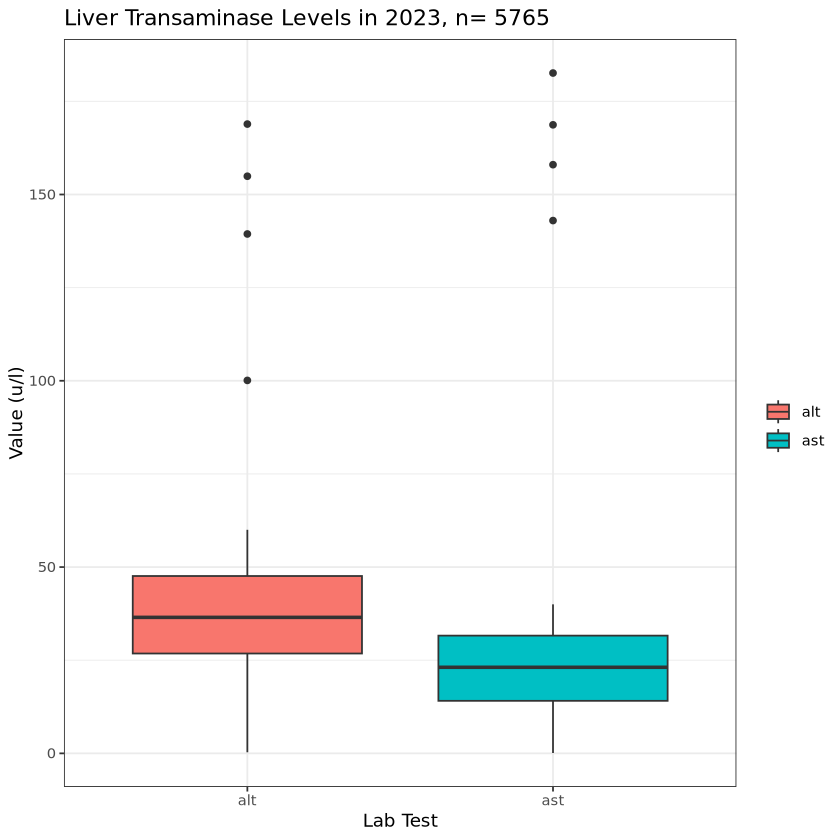

In [31]:
#creating a box plot graph of the results. 

ggplot(data=alt_ast)+
  geom_boxplot(aes(x=lab_test, y=value, fill= lab_test))+
  theme_bw()+
  labs(x= "Lab Test", y= "Value (u/l)", title= paste("Liver Transaminase Levels in 2023, n=", nrow(alt_ast)), fill= " ")

Let's say we are interested in a specific patient with epilepsy. 
Below, we plot the AST and ALT lab trends over the year 2023 for patient id # 1f9e58a1-0b6f-7f53-1495-8b05b69ad4ed.

You can modify this code for any patient of interest by changing the `patient_of_interest` variable.

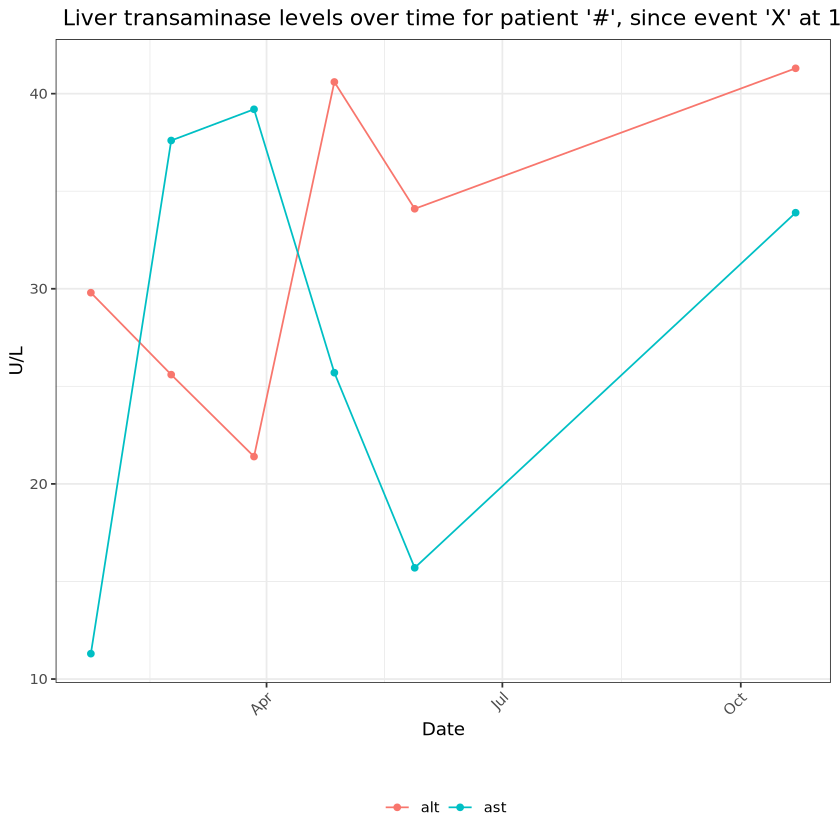

In [32]:
patient_of_interest <- 11641

#filtering for the specific patient's AST and ALT levels over time using the 2023 alt/ast dataframe we previously created: 

patient_group<- alt_ast %>% 
  filter(grepl(patient_of_interest, PATIENT_NUM))

### creating a plot showing the results over time: 

ggplot(data = patient_group) +
  geom_line( aes(x = TIMESTAMP, y = value, color = lab_test)) +
  geom_point( aes(x = TIMESTAMP, y = value, color = lab_test)) +
  theme_bw() +
  theme(
    legend.position = "bottom",  
    axis.text.x = element_text(angle = 45, hjust = 1) 
  )+
    labs(x = "Date", y = "U/L", title = " Liver transaminase levels over time for patient '#', since event 'X' at 1.1.2023", color =" ")+
  guides(color = guide_legend(nrow = 1, title.position = "top", title.hjust = 0.5))
  



## Investigating procedural data over time. Case study: Appendectomy.

Finally, let's take a look at the procedures data. 

The procedures are defined by CPT codes. 
We will explore the procedures in this data set and look at specific procedures of interest in a given time frame.

We can isolate the procedure related information by searching for 'ACT Procedures' in the CONCEPT_PATH column.

Below is an example of the procedures documented in this dataset.

In [33]:
# creating a list with unique procedures in the dataset : 

procedures <- data %>%
  filter(grepl("\\\\ACT Procedures", CONCEPT_PATH)) %>%
  distinct(CONCEPT_PATH, TVAL_CHAR) %>%
  rename(procedure=TVAL_CHAR)

Below, we filter the procedural data to identify a cohort of patients who have undergone an appendectomy since the beginning of 2020.


In [34]:
# filtering to create a new dataframe including patients with a history of an appendectomy procedure

appendectomy<- data %>%
  filter(grepl("Appendectomy", TVAL_CHAR)) %>%
  rename(procedure=TVAL_CHAR) %>%
  select(-CONCEPT_PATH, -NVAL_NUM) %>%
  distinct()

# filtering to only include patients who underwent an appendectomy since the beginning of the year 2020

appendectomy_2020<- appendectomy %>%
  filter(TIMESTAMP >= as.Date("2020-01-01")) %>%
  arrange(PATIENT_NUM)

head(appendectomy_2020)

PATIENT_NUM,procedure,TIMESTAMP,VARIABLE_TYPE,DATE
<dbl>,<chr>,<dttm>,<chr>,<date>
251,Appendectomy,2020-11-18 05:00:00,ACT Procedures CPT,2020-11-18
1210,Appendectomy,2021-11-18 05:00:00,ACT Procedures CPT,2021-11-18
1743,Appendectomy,2022-11-28 05:00:00,ACT Procedures CPT,2022-11-28
1759,Appendectomy,2021-08-31 04:00:00,ACT Procedures CPT,2021-08-31
2192,Appendectomy,2020-10-17 04:00:00,ACT Procedures CPT,2020-10-17
2371,Appendectomy,2022-01-02 05:00:00,ACT Procedures CPT,2022-01-02
